In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as f
from torchvision import datasets,transforms,utils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.optim as optim

In [25]:
torch.manual_seed(42)
batch_size = 128
lr = 1e-4
epochs = 10
noise_sigma = 0.2
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

In [26]:
transform = transforms.ToTensor()
train_data = datasets.CIFAR10(root="./data",train=True,download=True,transform=transform)
train_loader = DataLoader(train_data, batch_size=batch_size,num_workers=2,pin_memory=True)

In [27]:
class ConvDAE(nn.Module):
  def __init__(self, latent_dim=256):
    super().__init__()
    self.enc = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, 3, stride=2, padding=1), nn.ReLU(inplace=True),
    )
    self.to_latent = nn.Sequential(
        nn.Flatten(),
        nn.Linear(2048,latent_dim),
        nn.ReLU(inplace=True)
    )
    self.from_latent = nn.Sequential(nn.Linear(latent_dim, 2048), nn.ReLU(inplace=True))

    self.dec = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1), nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1), nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1), nn.Sigmoid()
    )
  def forward(self,x):
    h = self.enc(x)
    z = self.to_latent(h)
    h2 = self.from_latent(z)
    h2 = h2.view(-1,128,4,4)
    return self.dec(h2)
def add_noise(x,sigma=noise_sigma):
  return (x + sigma * torch.randn_like(x)).clamp(0.0,1.0)

model = ConvDAE().to(device)
opt = optim.Adam(model.parameters(),lr=lr)
criterion = nn.MSELoss()

for epoch in range(1,epochs+1):
  running = 0.0
  for clean , _ in train_loader:
    clean = clean.to(device)
    noisy = add_noise(clean)
    opt.zero_grad()
    denoised = model(noisy)
    loss = criterion(denoised,clean)
    loss.backward()
    opt.step()
    running += loss.item() * clean.size(0)
  print(f"Epoch {epoch:02d}/{epochs} | MSE: {running/len(train_loader.dataset):.6f}")



Epoch 01/10 | MSE: 0.045502
Epoch 02/10 | MSE: 0.024983
Epoch 03/10 | MSE: 0.022163
Epoch 04/10 | MSE: 0.020553
Epoch 05/10 | MSE: 0.019147
Epoch 06/10 | MSE: 0.018137
Epoch 07/10 | MSE: 0.017225
Epoch 08/10 | MSE: 0.015937
Epoch 09/10 | MSE: 0.014414
Epoch 10/10 | MSE: 0.013670


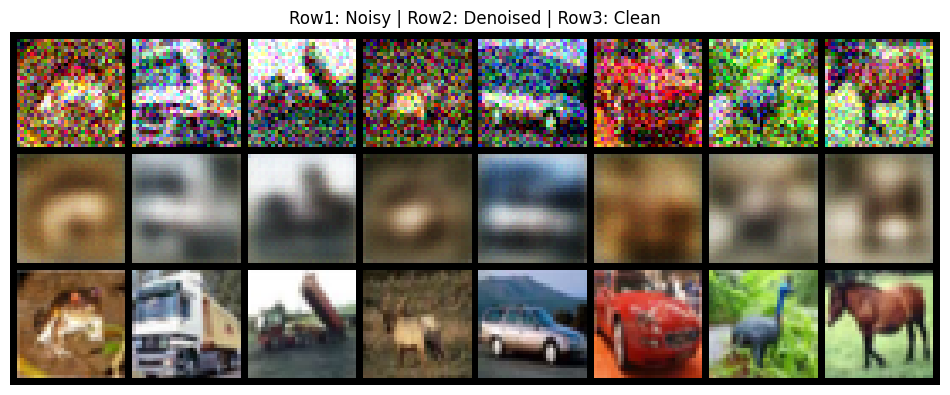

In [29]:
model.eval()
clean , _ = next(iter(train_loader))
clean = clean.to(device)
noisy = add_noise(clean)

with torch.no_grad():
  denoised = model(noisy)
show = torch.cat([noisy[:8],denoised[:8],clean[:8]])
grid = utils.make_grid(show,nrow=8)
plt.figure(figsize=(12,5))
plt.imshow(grid.permute(1,2,0).cpu().numpy())
plt.axis("off")
plt.title("Row1: Noisy | Row2: Denoised | Row3: Clean")
plt.show()